In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

# Problem 1

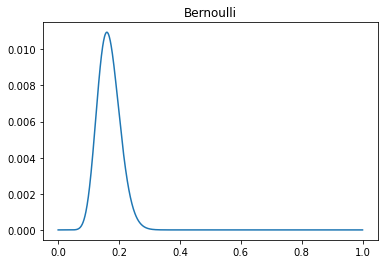

0.16016016016016016


In [5]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    linspace = np.linspace(0,1,1000)
    s = np.random.binomial(n,p)
    
    pmf = linspace**s*(1-linspace)**(n-s)
    
    sm = linspace**s*(1-linspace)**(n-s)
    denominator = np.sum(sm)
    
    posterior = pmf/denominator
    
    index = np.argmax(posterior)
    
    MAP = linspace[index]
    
    plt.plot(linspace, posterior)
    plt.title("Bernoulli")
    plt.show()
    
    return MAP
    
x = bernoulli_sampling(.2,100)
print(x)

# Problem 2

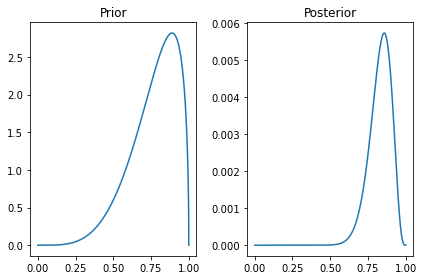

0.8568568568568569


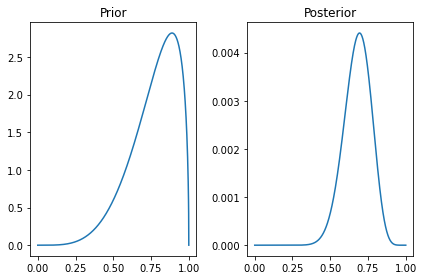

0.6936936936936937


In [6]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    
    linspace = np.linspace(0,1,1000)
    prior_pdf = [prior.pdf(p) for p in linspace]
    #print(prior_pdf)
    
    plt.subplot(121)
    plt.plot(linspace,prior_pdf)
    plt.title("Prior")
    
    s = np.random.binomial(n,p)
    
    pmf = linspace**s*(1-linspace)**(n-s)
    
    numerator = pmf*prior_pdf
    
    sm = (linspace**s*(1-linspace)**(n-s))*prior_pdf
    denominator = np.sum(sm)
    
    posterior = numerator/denominator
 
    plt.subplot(122)
    plt.plot(linspace,posterior)
    plt.title("Posterior")
    plt.tight_layout()
    plt.show()
    
    index = np.argmax(posterior)
    
    MAP = linspace[index]
    
    return MAP
    
    
print(non_uniform_prior(.9,20,beta(5,1.5)))
print(non_uniform_prior(.5,20,beta(5,1.5)))
    
    

# Problem 3

In [7]:
class MarkovChain:
    """A Markov chain with finitely many states.

    Attributes:
        self.A: A (n,n) matrix that should be column-stochaastic
        self.labels: A list of the labels
        self.dictionary: A dictionary where the keys are the rows of A
            and the values are the states
    """
    # Problem 1
    def __init__(self, A, states=None):
        """Check that A is column stochastic and construct a dictionary
        mapping a state's label to its index (the row / column of A that the
        state corresponds to). Save the transition matrix, the list of state
        labels, and the label-to-index dictionary as attributes.

        Parameters:
        A ((n,n) ndarray): the column-stochastic transition matrix for a
            Markov chain with n states.
        states (list(str)): a list of n labels corresponding to the n states.
            If not provided, the labels are the indices 0, 1, ..., n-1.

        Raises:
            ValueError: if A is not square or is not column stochastic.

        Example:
            >>> MarkovChain(np.array([[.5, .8], [.5, .2]], states=["A", "B"])
        corresponds to the Markov Chain with transition matrix
                                   from A  from B
                            to A [   .5      .8   ]
                            to B [   .5      .2   ]
        and the label-to-index dictionary is {"A":0, "B":1}.
        """
        #make a dictionary
        self.dictionary = {}
        
        #Check if A is column stochastic
        if np.allclose(A.sum(axis=1), np.ones(A.shape[1])) == False:
            raise ValueError("A is not column stochastic")
            
        #Create your attributes
        if states == None:
            m,n = A.shape
            states = [i for i in range(n)]
            
        for i, state in enumerate(states):
            self.dictionary[state] = i
            
        self.A = A
        self.labels = states
            
        

    # Problem 2
    def transition(self, state):
        """Transition to a new state by making a random draw from the outgoing
        probabilities of the state with the specified label.

        Parameters:
            state (str): the label for the current state.

        Returns:
            (str): the label of the state to transitioned to.
        """
        
        index = self.dictionary[state]
        #Take a random available entry
        newcolumn = np.random.multinomial(1, np.array(self.A[:,index]))
        
        newindex = np.argmax(newcolumn)
        
        #print(self.labels[newindex])
        
        return self.labels[newindex]
        

    # Problem 3
    def walk(self, start, N):
        """Starting at the specified state, use the transition() method to
        transition from state to state N-1 times, recording the state label at
        each step.

        Parameters:
            start (str): The starting state label.

        Returns:
            (list(str)): A list of N state labels, including start.
        """
        
        labels = []
        state = start
        #Walk through the nodes N-1 times calling transition
        for i in range(N-1):
            labels.append(self.transition(state))
            state = labels[i]
            
            
        labels.insert(0,start)
        
        return labels

In [8]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    
    MC = MarkovChain(transition_matrix)
    
    forecast = MC.walk(0,10)
    
    weather = []
    for i in range(days):
        if forecast[i] == 0:
            weather.append("sun")
        elif forecast[i] == 1:
            weather.append("rain")
        else:
            weather.append("wind")
            
    
    return weather



In [9]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

print(weather_forecast(transition_matrix))

['sun', 'sun', 'sun', 'rain', 'rain', 'wind', 'rain', 'wind', 'wind', 'rain']


# Problem 4

In [10]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    model = pm.Model()
    with model:
        lam = pm.Beta('lambda', alpha = 1, beta = 1)
        y = pm.Bernoulli('y', p=lam, observed = data)
        trace = pm.sample(n)
        
        az.plot_trace(trace)
        lam = trace['lambda']
        mean = lam.mean()    
    
    return mean


<ipython-input-10-fc05dfa2a603>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


0.15540023215930057


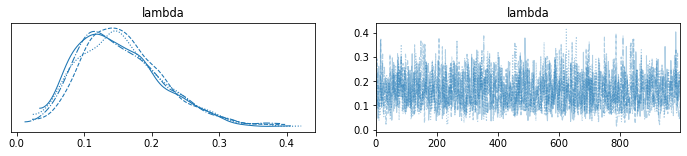

In [11]:
data = bernoulli.rvs(0.2, size=30)
print(posterior_sampling(data))

# Problem 5

In [12]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    
    model = pm.Model()
    with model:
        mu = pm.Normal('mu', mu = m, sigma = s)
        tau =pm.Gamma('tau', alpha = alpha, beta = beta)
        
        y = pm.Normal('y', mu = mu, sigma = 1/tau, observed = observed_heights)
        trace = pm.sample(n)
        
        az.plot_trace(trace)
        mu = trace['mu']
        tau = trace['tau']
        mean = mu.mean()    
    
    return mean

<ipython-input-12-44565c236fe3>:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bryan\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bryan\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bryan\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 229 seconds.


181.29594764680186


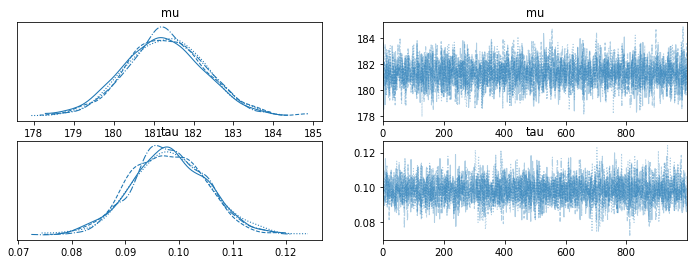

In [13]:
heights = np.random.normal(180,10,100)
print(height_model(heights))